In [119]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer,AutoModel
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import io
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
df = pd.read_csv("sentiment_analysis_dataset.csv", engine='python', on_bad_lines='skip',encoding='utf-8')


In [19]:
df.shape

(6739, 2)

In [20]:
df.isna().sum()
df.dropna(inplace=True)
df.shape

(6734, 2)

In [21]:
df.Sentiment.value_counts()  # damn class inbalance

Sentiment
Positive    4679
Neutral     1976
Negative      79
Name: count, dtype: int64

In [22]:
# classes,counts = np.unique(df.Sentiment,return_counts=True)
# weight = 1.0/counts
# weights = weight/weight.sum() * len(classes)
# class_weights = torch.tensor(weights,dtype=torch.float32)
# class_weights


tensor([2.8386, 0.1135, 0.0479])

In [68]:
class_weights = compute_class_weight('balanced',classes=np.unique(df.Sentiment),y=df.Sentiment)
class_weights = torch.tensor(class_weights,dtype=torch.float32).to(device)


In [23]:
X_train,X_temp,Y_train,Y_temp = train_test_split(df['Comment'],df['Sentiment'],test_size=.3,stratify=df.Sentiment,random_state=60)
X_val,X_test,Y_val,Y_test = train_test_split(X_temp,Y_temp,test_size=.5,stratify=Y_temp,random_state=60)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(df.Sentiment)

LabelEncoder()

In [87]:
class CustomDataset(Dataset):
    def __init__(self,X,Y):
        self.X = [tokenizer(x,max_length=100,truncation=True,padding='max_length',return_tensors='pt').to(device) for x in X]
        self.Y = torch.tensor(label_encoder.transform(Y),dtype=torch.long).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        return self.X[index],self.Y[index]

In [88]:
train_dataset = CustomDataset(X_train,Y_train.values)
val_dataset = CustomDataset(X_val,Y_val.values)
test_dataset=CustomDataset(X_test,Y_test.values)

In [110]:
batch_size = 32
LR=5e-4
EPOCHS=20

In [111]:
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
val_loader=DataLoader(val_dataset,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


In [112]:
class MyModule(nn.Module):
    def __init__(self,bert,num_classes):
        super().__init__()
        self.bert= bert
        self.dropout = nn.Dropout(.2)
        self.linear1 = nn.Linear(768,334)
        self.ReLu=nn.ReLU()
        self.linear2=nn.Linear(334,num_classes)

    def forward(self,input_ids,attention_mask):
        pooled_opt =self.bert(input_ids,attention_mask,return_dict=False)[0][:,0]
        output = self.linear1(pooled_opt)
        output=self.ReLu(output)
        output=self.dropout(output)
        output = self.linear2(output)
        output=self.ReLu(output)
        output=self.dropout(output)
        return output

In [113]:
for param in bert_model.parameters():
    param.requires_grad = False
mymodel = MyModule(bert_model,df.Sentiment.nunique()).to(device)

In [114]:
critertion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(mymodel.parameters(),lr=LR)

In [115]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

In [116]:
best_score= 0

for epoch in range(EPOCHS):
    mymodel.train()
    total_train_acc = 0
    total_train_loss = 0
    for input,label in tqdm(train_loader,desc='Training',leave=False):
        input,label = input.to(device),label.to(device)
        optimizer.zero_grad()

        output = mymodel(input['input_ids'].squeeze(1),input['attention_mask'].squeeze(1)).squeeze(1)
        train_loss = critertion(output,label)

        train_loss.backward()
        optimizer.step()

        total_train_loss +=train_loss.item()*input['input_ids'].size(0)
        train_acc = (torch.argmax(output,axis=1)==label).sum().item()
        total_train_acc += train_acc
    
    avg_train_loss =total_train_loss/len(train_dataset)
    avg_train_acc = total_train_acc/len(train_dataset)

    mymodel.eval()
    total_val_acc = 0
    total_val_loss=0
    
    with torch.no_grad():
        for input,label in val_loader:
            input,label = input.to(device),label.to(device)
            output = mymodel(input['input_ids'].squeeze(1),input['attention_mask'].squeeze(1)).squeeze(1)

            val_loss = critertion(output,label)
            total_val_loss +=val_loss.item()*input['input_ids'].size(0)

            val_acc = (torch.argmax(output,axis=1)==label).sum().item()
            total_val_acc +=val_acc

        

        avg_val_loss = total_val_loss/len(val_dataset)
        avg_val_acc = total_val_acc/len(val_dataset)

    total_loss_train_plot.append(round(avg_train_loss,2))
    total_acc_train_plot.append(round(avg_train_acc*100,2))
    total_loss_val_plot.append(round(avg_val_loss,2))
    total_acc_val_plot.append(round(avg_val_acc*100,2))

    print(f'Epoch:{epoch+1}/{EPOCHS} Train loss: {total_loss_train_plot[epoch]}, Train Acc: {total_acc_train_plot[epoch]}%')
    print(f'Epoch:{epoch+1}/{EPOCHS} Val Loss: {total_loss_val_plot[epoch]}, Val acc: {total_acc_val_plot[epoch]}%')


    if avg_val_acc > best_score:
        best_score=avg_val_acc
        torch.save(mymodel.state_dict(),'Best_model_MrBeastComments.pth')
        print(f'Model saved with val acc:{round(avg_val_acc*100,2)}%')

Training:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch:1/20 Train loss: 0.9, Train Acc: 60.75%
Epoch:1/20 Val Loss: 0.72, Val acc: 83.66%
Model saved with val acc:83.66%


Epoch:2/20 Train loss: 0.76, Train Acc: 67.3%
Epoch:2/20 Val Loss: 0.73, Val acc: 78.71%


Epoch:3/20 Train loss: 0.74, Train Acc: 66.39%
Epoch:3/20 Val Loss: 0.6, Val acc: 84.95%
Model saved with val acc:84.95%


Epoch:4/20 Train loss: 0.7, Train Acc: 66.48%
Epoch:4/20 Val Loss: 0.56, Val acc: 86.34%
Model saved with val acc:86.34%


Epoch:5/20 Train loss: 0.7, Train Acc: 68.79%
Epoch:5/20 Val Loss: 0.58, Val acc: 85.64%


Epoch:6/20 Train loss: 0.7, Train Acc: 66.73%
Epoch:6/20 Val Loss: 0.6, Val acc: 84.16%


Epoch:7/20 Train loss: 0.68, Train Acc: 67.28%
Epoch:7/20 Val Loss: 0.55, Val acc: 82.87%


Epoch:8/20 Train loss: 0.68, Train Acc: 68.94%
Epoch:8/20 Val Loss: 0.51, Val acc: 85.45%


Epoch:9/20 Train loss: 0.64, Train Acc: 68.85%
Epoch:9/20 Val Loss: 0.51, Val acc: 87.52%
Model saved with val acc:87.52%


Epoch:10/20 Train loss: 0.65, Train Acc: 69.02%
Epoch:10/20 Val Loss: 0.46, Val acc: 88.91%
Model saved with val acc:88.91%


Epoch:11/20 Train loss: 0.65, Train Acc: 68.58%
Epoch:11/20 Val Loss: 0.5, Val acc: 88.91%


Epoch:12/20 Train loss: 0.64, Train Acc: 70.32%
Epoch:12/20 Val Loss: 0.46, Val acc: 88.51%


Epoch:13/20 Train loss: 0.64, Train Acc: 69.83%
Epoch:13/20 Val Loss: 0.45, Val acc: 89.21%
Model saved with val acc:89.21%


Epoch:14/20 Train loss: 0.64, Train Acc: 69.21%
Epoch:14/20 Val Loss: 0.45, Val acc: 89.7%
Model saved with val acc:89.7%


Epoch:15/20 Train loss: 0.64, Train Acc: 69.76%
Epoch:15/20 Val Loss: 0.46, Val acc: 88.81%


Epoch:16/20 Train loss: 0.6, Train Acc: 71.46%
Epoch:16/20 Val Loss: 0.46, Val acc: 89.9%
Model saved with val acc:89.9%


Epoch:17/20 Train loss: 0.64, Train Acc: 69.91%
Epoch:17/20 Val Loss: 0.43, Val acc: 89.5%


Epoch:18/20 Train loss: 0.61, Train Acc: 70.97%
Epoch:18/20 Val Loss: 0.46, Val acc: 90.99%
Model saved with val acc:90.99%


Epoch:19/20 Train loss: 0.61, Train Acc: 71.59%
Epoch:19/20 Val Loss: 0.44, Val acc: 90.59%


Epoch:20/20 Train loss: 0.62, Train Acc: 70.61%
Epoch:20/20 Val Loss: 0.45, Val acc: 91.88%
Model saved with val acc:91.88%


In [118]:
from sklearn.metrics import classification_report ,confusion_matrix

In [120]:
all_preds = []
all_labels=[]

with torch.no_grad():
    for input,label in test_loader:
        input,label = input.to(device),label.to(device)
        output = mymodel(input['input_ids'].squeeze(1),input['attention_mask'].squeeze(1)).squeeze(1)
        preds = torch.argmax(output,axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    
print(classification_report(all_labels, all_preds, target_names=['Negative','Neutral','Positive']))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

    Negative       0.41      0.92      0.56        12
     Neutral       0.83      0.94      0.88       297
    Positive       0.98      0.91      0.94       702

    accuracy                           0.91      1011
   macro avg       0.74      0.92      0.80      1011
weighted avg       0.93      0.91      0.92      1011

[[ 11   0   1]
 [  6 278  13]
 [ 10  56 636]]


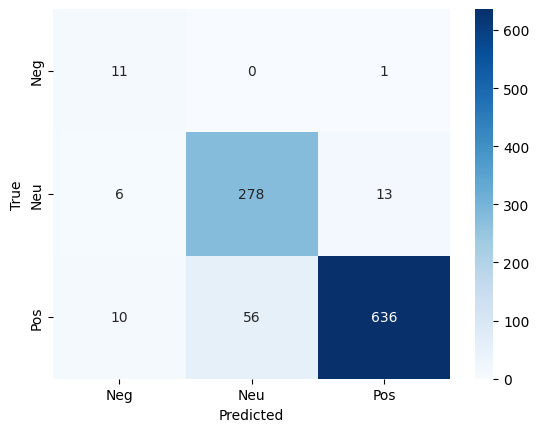

In [129]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg','Neu','Pos'],
            yticklabels=['Neg','Neu','Pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [160]:
def predict(model,text):
    model.eval()
    inputs = tokenizer(text,max_length=100,truncation=True,padding='max_length',return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
        preds = torch.argmax(output,axis=1).item()
        probs = torch.softmax(output,dim=1).cpu().numpy().flatten()
        top_indicides =probs.argsort()[::-1]
        top_labels = label_encoder.inverse_transform(top_indicides)
        top_preds = [(label,float(probs[x])) for label,x in zip(top_labels,top_indicides)]
            
        print((top_preds))
        prediction= label_encoder.inverse_transform([preds])[0]
        return {'Prediction':prediction}    
        
        

In [180]:
predict(mymodel,'MrBeast sucks')

[('Positive', 0.5597846508026123), ('Neutral', 0.2205425649881363), ('Negative', 0.2196727991104126)]


{'Prediction': 'Positive'}